In [67]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import yfinance as yf
import seaborn as sns
import prophet as pt
import time
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr

sns.set_style('whitegrid')
plt.style.use("default")
yf.pdr_override()
%matplotlib inline


In [68]:
end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(days=365 * 1)
df = pdr.get_data_yahoo('AAPL', start_date, end_date)
display(df.head())


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-10-10,140.419998,141.889999,138.570007,140.419998,139.591888,74899000
2022-10-11,139.899994,141.350006,138.220001,138.979996,138.160370,77033700
2022-10-12,139.130005,140.360001,138.160004,138.339996,137.524155,70433700
2022-10-13,134.990005,143.589996,134.369995,142.990005,142.146729,113224000
2022-10-14,144.309998,144.520004,138.190002,138.380005,137.563919,88598000


In [69]:
class DeepEvolutionStrategy:

    inputs = None

    def __init__(
        self, weights, reward_function, population_size, sigma, learning_rate
    ):
        self.weights = weights
        self.reward_function = reward_function
        self.population_size = population_size
        self.sigma = sigma
        self.learning_rate = learning_rate

    def _get_weight_from_population(self, weights, population):
        weights_population = []
        for index, i in enumerate(population):
            jittered = self.sigma * i
            weights_population.append(weights[index] + jittered)
        return weights_population

    def getWeights(self):
        return self.weights

    def train(self, epoch=100, print_every=1):
            lasttime = time.time()
            for i in range(epoch):
                population = []
                rewards = np.zeros(self.population_size)
                for k in range(self.population_size):
                    x = []
                    for w in self.weights:
                        x.append(np.random.randn(*w.shape))
                    population.append(x)
                for k in range(self.population_size):
                    weights_population = self._get_weight_from_population(
                        self.weights, population[k]
                    )
                    rewards[k] = self.reward_function(weights_population)
                rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-7)
                for index, w in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    self.weights[index] = (
                        w
                        + self.learning_rate
                        / (self.population_size * self.sigma)
                        * np.dot(A.T, rewards).T
                    )
                if (i + 1) % print_every == 0:
                    print(
                        f'Training Epoch {i + 1}. Final Reward: {self.reward_function(self.weights)}'
                    )
            print('=====================================')
            print(f'Training Time: {time.time() - lasttime} seconds')


class Model:
    def __init__(self, input_size, layer_size, output_size):
        self.weights = [
            np.random.randn(input_size, layer_size),
            np.random.randn(layer_size, output_size),
            np.random.randn(1, layer_size),
        ]

    def predict(self, inputs):
        feed = np.dot(inputs, self.weights[0]) + self.weights[-1]
        decision = np.dot(feed, self.weights[1])
        return decision

    def getWeights(self):
        return self.weights

    def set_weights(self, weights):
        self.weights = weights

    def save_model(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self.weights, file)

    def load_model(self, filename):
        with open(filename, 'rb') as file:
            self.weights = pickle.load(file)


In [70]:
class Agent:

    POPULATION_SIZE = 15
    SIGMA = 0.1
    LEARNING_RATE = 0.03

    def __init__(self, model, window_size, trend, skip, initial_money):
        self.model = model
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.es = DeepEvolutionStrategy(
            self.model.getWeights(),
            self.getReward,
            self.POPULATION_SIZE,
            self.SIGMA,
            self.LEARNING_RATE,
        )

    def act(self, sequence):
        decision = self.model.predict(np.array(sequence))
        return np.argmax(decision[0])

    def getState(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def getReward(self, weights):
        initial_money = self.initial_money
        starting_money = initial_money
        self.model.weights = weights
        state = self.getState(0)
        inventory = []
        quantity = 0
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                starting_money -= close[t]

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                starting_money += self.trend[t]

            state = next_state
        return ((starting_money - initial_money) / initial_money) * 100

    def fit(self, iterations, checkpoint):
        self.es.train(iterations, print_every=checkpoint)

    def buy(self):
        initial_money = self.initial_money
        state = self.getState(0)
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            next_state = self.getState(t + 1)

            if action == 1 and initial_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('Day %s > Buy 1 share at price %s, Total Asset %s' % (
                    str(t).rjust(3),
                    str("%.5f" % self.trend[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10)
                ))

            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print('Day %s > Sell 1 share at price %s, Total Asset %s > Profit %s %%' % (
                    str(t).rjust(3),
                    str("%.5f" % close[t]).rjust(10),
                    str("%.3f" % initial_money).rjust(10),
                    str("%.2f" % invest).rjust(5)
                ))
            state = next_state

        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest


In [71]:
close = df.Close.values.tolist()
window_size = 30
skip = 1
initial_money = 10000


In [72]:
# model.load_model('D:\Time-series-forecasting\model\deepES_model_AAPL.hdf5')


In [73]:
model = Model(input_size = window_size, layer_size = 500, output_size = 3)
agent = Agent(model = model,
              window_size = window_size,
              trend = close,
              skip = skip,
              initial_money = initial_money)
agent.fit(iterations = 500, checkpoint = 100)

model.save_model('D:\Time-series-forecasting\model\deepES_model_AAPL_10y.hdf5')


Training Epoch 100. Final Reward: 11.186100692749024
Training Epoch 200. Final Reward: 12.516100540161132
Training Epoch 300. Final Reward: 12.806300888061523
Training Epoch 400. Final Reward: 13.008700637817384
Training Epoch 500. Final Reward: 13.661200637817384
Training Time: 433.5943286418915 seconds


In [74]:
states_buy, states_sell, total_gains, invest = agent.buy()


Day   1 > Buy 1 share at price  138.98000, Total Asset   9861.020
Day   2 > Buy 1 share at price  138.34000, Total Asset   9722.680
Day   4 > Sell 1 share at price  138.38000, Total Asset   9861.060 > Profit -0.43 %
Day   6 > Buy 1 share at price  143.75000, Total Asset   9717.310
Day   7 > Sell 1 share at price  143.86000, Total Asset   9861.170 > Profit  3.99 %
Day   8 > Buy 1 share at price  143.39000, Total Asset   9717.780
Day  10 > Buy 1 share at price  149.45000, Total Asset   9568.330
Day  11 > Sell 1 share at price  152.34000, Total Asset   9720.670 > Profit  5.98 %
Day  12 > Buy 1 share at price  149.35001, Total Asset   9571.320
Day  13 > Buy 1 share at price  144.80000, Total Asset   9426.520
Day  15 > Sell 1 share at price  153.34000, Total Asset   9579.860 > Profit  6.94 %
Day  16 > Sell 1 share at price  150.64999, Total Asset   9730.510 > Profit  0.80 %
Day  17 > Buy 1 share at price  145.03000, Total Asset   9585.480
Day  19 > Buy 1 share at price  138.38000, Total Ass

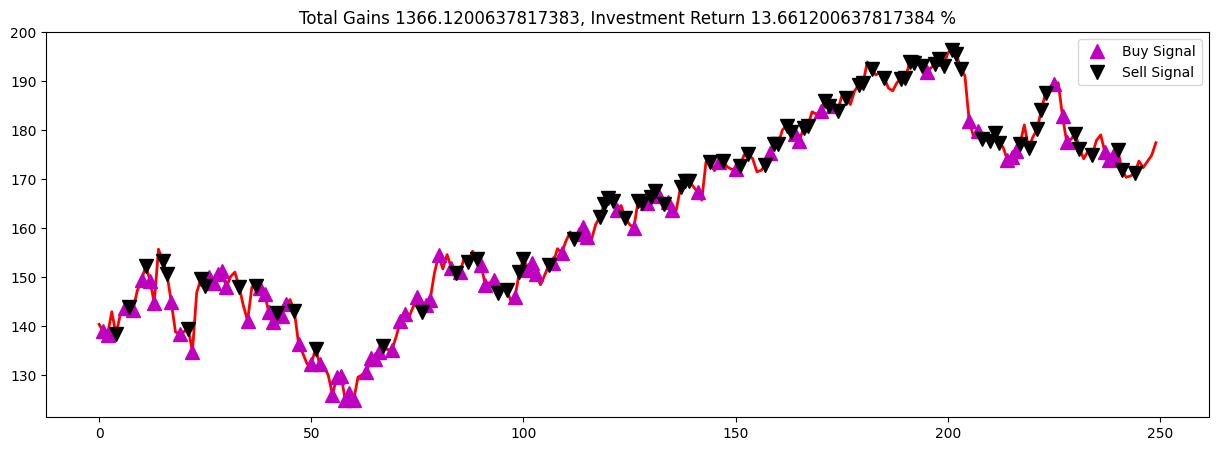

In [75]:
fig = plt.figure(figsize=(15, 5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label='Buy Signal', markevery=states_buy)
plt.plot(close, 'v', markersize=10, color='k', label='Sell Signal', markevery=states_sell)
plt.title(f'Total Gains {total_gains}, Investment Return {invest} %')
plt.legend()
plt.show()
